# Decompile video frames into folder of images

In [17]:
import cv2
import os

def extract_frames(video_path, output_folder):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video_capture.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    frame_count = 0
    while True:
        # Read the next frame from the video
        success, frame = video_capture.read()

        # If reading a frame was unsuccessful, exit the loop
        if not success:
            break

        # Define the output filename with zero-padded numbering
        output_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")

        # Save the frame as an image
        cv2.imwrite(output_filename, frame)

        # Print progress
        print(f"Saved: {output_filename}")

        # Increment the frame count
        frame_count += 1

    # Release the video capture object
    video_capture.release()
    print("Done! All frames have been extracted.")

video_file = "video_1.avi"        # Video file to be extracted
output_directory = "extracted_frames" # Folder to save images
# extract_frames(video_file, output_directory)


# (DIDN'T WORK) Video Stabilization (https://learnopencv.com/video-stabilization-using-point-feature-matching-in-opencv/)   

In [ ]:
# Import numpy and OpenCV
import numpy as np
import cv2
import matplotlib.pyplot as plt
 
# Read input video
video_src = "video_1_otsu_threshold.avi"
cap = cv2.VideoCapture(video_src)
 
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
# Define the codec for output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
 
# Set up output video
out = cv2.VideoWriter('video_1_otsu_stabilized.avi', fourcc, 25, (w, h))

# Read first frame
_, prev = cap.read() 
 
# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

# plt.imshow(prev_gray)
# print(type(prev_gray))



In [ ]:
# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32) 
 
for i in range(n_frames-2):
  # Detect feature points in previous frame
  prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
 
  # Read next frame
  success, curr = cap.read()  
  if not success:
    print("read frame not successful")
    break
 
  # Convert to grayscale
  curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 
 
  # Calculate optical flow (i.e. track feature points)
  curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 
 
  # Sanity check
  assert prev_pts.shape == curr_pts.shape 
 
  # Filter only valid points
  idx = np.where(status==1)[0]
  prev_pts = prev_pts[idx]
  curr_pts = curr_pts[idx]
 
  #Find transformation matrix
  m = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False) #will only work with OpenCV-3 or less
 
  # Extract traslation
  dx = m[0,2]
  dy = m[1,2]
 
  # Extract rotation angle
  da = np.arctan2(m[1,0], m[0,0])
 
  # Store transformation
  transforms[i] = [dx,dy,da]
 
  # Move to next frame
  prev_gray = curr_gray
 
  print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))

In [50]:
# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0)
# print(trajectory)

In [51]:
def movingAverage(curve, radius):
  window_size = 2 * radius + 1
  # Define the filter
  f = np.ones(window_size)/window_size
  # Add padding to the boundaries
  curve_pad = np.lib.pad(curve, (radius, radius), 'edge')
  # Apply convolution
  curve_smoothed = np.convolve(curve_pad, f, mode='same')
  # Remove padding
  curve_smoothed = curve_smoothed[radius:-radius]
  # return smoothed curve
  return curve_smoothed

def smooth(trajectory, smoothing_radius):
  smoothed_trajectory = np.copy(trajectory)
  # Filter the x, y and angle curves
  for i in range(3):
    smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=smoothing_radius)
 
  return smoothed_trajectory

In [52]:
# Calculate smoothed trajectory
smoothed_trajectory = smooth(trajectory, 5)

In [53]:
# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory
# difference = smooth(trajectory) - trajectory
 
# Calculate newer transformation array
transforms_smooth = transforms + difference

In [54]:
def fixBorder(frame):
  s = frame.shape
  # Scale the image 4% without moving the center
  T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
  frame = cv2.warpAffine(frame, T, (s[1], s[0]))
  return frame

In [55]:
def fixBorder(frame):
  s = frame.shape
  # Scale the image 4% without moving the center
  T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
  frame = cv2.warpAffine(frame, T, (s[1], s[0]))
  return frame

In [56]:
# Reset stream to first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 
 
# Write n_frames-1 transformed frames
for i in range(n_frames-2):
  # Read next frame
  success, frame = cap.read()
  if not success:
    print("read frame unsuccessful")
    break
 
  # Extract transformations from the new transformation array
  dx = transforms_smooth[i,0]
  dy = transforms_smooth[i,1]
  da = transforms_smooth[i,2]
 
  # Reconstruct transformation matrix accordingly to new values
  m = np.zeros((2,3), np.float32)
  m[0,0] = np.cos(da)
  m[0,1] = -np.sin(da)
  m[1,0] = np.sin(da)
  m[1,1] = np.cos(da)
  m[0,2] = dx
  m[1,2] = dy
 
  # Apply affine wrapping to the given frame
  frame_stabilized = cv2.warpAffine(frame, m, (w,h))
 
  # Fix border artifacts
  frame_stabilized = fixBorder(frame_stabilized) 
 
  # Write the frame to the file
  frame_out = cv2.hconcat([frame, frame_stabilized])
 
  # If the image is too big, resize it.
  if(frame_out.shape[1] > 1920):
    frame_out = cv2.resize(frame_out, (int(frame_out.shape[1]/2), int(frame_out.shape[0]/2)))
 
  cv2.imshow("Before and After", frame_out)
  cv2.waitKey(10)
  out.write(frame_out)

In [57]:
out.release()
cap.release()
cv2.destroyAllWindows()

# VIDEO THRESHOLDING

Naive thresholding + Gaussian blur

In [ ]:
import cv2
import numpy as np
import sys
import os
from datetime import datetime
from utils import *

# Read file
video = "video_1.avi"
cap = cv2.VideoCapture(video)


# Error check 
if not cap.isOpened():
    print("Error: video could not be opened")
    exit()

threshold_value = 30 # --- ADJUSTABLE PARAMETER ---

# Output file 
write_to_file = False
video_out = f"video_1_naive_threshold_{threshold_value}.avi"
# video_out = "demo_1_video_stabilization.avi"
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(video_out, fourcc, 25, (2*w, h))

print_last_modified(video_out)


while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        print("End of file or cannot read frame.")
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # gray_frame_blur = cv2.GaussianBlur(gray_frame, (31,31), 0)
    gray_frame = cv2.GaussianBlur(gray_frame, (31,31), 0) # Denoising step

    _, thresholded_frame = cv2.threshold(gray_frame, threshold_value, 255, cv2.THRESH_BINARY)

    combined_frame = cv2.hconcat([gray_frame, thresholded_frame])
    # combined_frame = cv2.hconcat([gray_frame, gray_frame_blur])

    # If the image is too big, resize it.
    if(combined_frame.shape[1] > 1920):
        combined_frame = cv2.resize(combined_frame, (int(combined_frame.shape[1]/2), int(combined_frame.shape[0]/2)))

    w, h = combined_frame.shape[0], combined_frame.shape[1]
    # print(combined_frame.shape)

    cv2.imshow("Original (left) vs. Thresholded (right)", combined_frame)

    # frame_out = cv2.cvtColor(thresholded_frame, cv2.COLOR_GRAY2BGR)
    frame_out = cv2.cvtColor(combined_frame, cv2.COLOR_GRAY2BGR)
    if write_to_file: output.write(frame_out)

    if cv2.waitKey(1) == ord('q'): 
        break

cap.release()
if write_to_file: output.release()
cv2.destroyAllWindows()


Otsu's thresholding

In [ ]:
import cv2
import numpy as np

# Input and output files
video_src = "video_1.avi"
cap = cv2.VideoCapture(video_src)

video_out = "video_1_otsu_threshold.avi"
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
output = cv2.VideoWriter(video_out, fourcc, 25, (w, h))

# Sanity check
if not cap.isOpened():
    print("Error: video file could not be read.")
    exit()

while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        print("End of file or frame could not be read.")
        break

    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Otsu's thresholding
    _, otsu_thresholded_frame = cv2.threshold(gray_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Horizontally concatenate the original and thresholded images
    combined_frame = cv2.hconcat([gray_frame, otsu_thresholded_frame])

    # Resize to fit inside screen
    if(combined_frame.shape[1] > 1920):
        scale_factor = 1/2
        combined_frame = cv2.resize(combined_frame, (int(combined_frame.shape[1]*scale_factor), int(combined_frame.shape[0]*scale_factor)))

    # Preview images
    cv2.imshow("Original (left) vs. Otsu Thresholded (right)", combined_frame)
    
    # Write to file
    frame_out = cv2.cvtColor(otsu_thresholded_frame, cv2.COLOR_GRAY2BGR)
    output.write(frame_out)

    # Press 'q' to exit
    if cv2.waitKey(10) & 0xFF == ord('q'): 
        break


# Release resources
cap.release()
output.release()
cv2.destroyAllWindows()


# THRESHOLD-BASED STABILIZATION

In [ ]:
import cv2
import numpy as np

# Input and output video files
input_file = "video_1_naive_threshold.avi"
output_file = "video_1_naive_threshold_centered.avi"

# Open the input video
cap = cv2.VideoCapture(input_file)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create the output 
write_to_file = False
if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

if not cap.isOpened():
    print("Error: Could not open input video.")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video or cannot fetch frame.")
        break

    # Ensure the frame is grayscale
    if len(frame.shape) == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find non-zero (white) pixels
    non_zero_coords = cv2.findNonZero(frame)
    if non_zero_coords is None and write_to_file:
        # No object detected, write original frame and continue
        out.write(frame)
        continue

    # Compute centroid of the white pixels
    M = cv2.moments(frame, binaryImage=True)
    if M['m00'] != 0:
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])
    else:
        centroid_x, centroid_y = frame_width // 2, frame_height // 2  # Default center if no mass

    # Draw centroid 
    cv2.circle(frame, (round(centroid_x), round(centroid_y)), 3, (0, 0, 255), -1)
    # cv2.circle(frame_out, (int(rotated_midpoint[0]), int(rotated_midpoint[1])), 3, (0, 0, 255), -1)

    # Calculate translation to center the object
    offset_x = (frame_width // 2) - centroid_x
    offset_y = (frame_height // 2) - centroid_y

    # Create translation matrix
    translation_matrix = np.float32([[1, 0, offset_x], [0, 1, offset_y]])

    # Translate the image
    centered_frame = cv2.warpAffine(frame, translation_matrix, (frame_width, frame_height))

    # Write the centered frame to the output video
    if write_to_file: out.write(centered_frame)

    # Display the result for debugging
    cv2.imshow("Centered Frame", centered_frame)

    # Exit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
if write_to_file: out.release()
cv2.destroyAllWindows()


Apply the translations computed from the thresholded video to the original video

In [ ]:
import cv2
import numpy as np
from utils import *

# Input files
input_file = "video_1_naive_threshold.avi"  # Thresholded video
to_be_corrected_file = "video_1.avi"  # Second video to 

# Output files
write_to_file = False
output_file = "video_1_corrected_naive_threshold.avi"  # Translated output video

# File info
print_last_modified(input_file)
print_last_modified(output_file)

# Open the thresholded video
cap_thresholded = cv2.VideoCapture(input_file)

# Open the video to be corrected
cap_to_correct = cv2.VideoCapture(to_be_corrected_file)

# Get video properties
fps = int(cap_thresholded.get(cv2.CAP_PROP_FPS))
frame_width = int(cap_thresholded.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap_thresholded.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create the output video writer
if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

if not cap_thresholded.isOpened() or not cap_to_correct.isOpened():
    print("Error: Could not open one or both input videos.")
    exit()

while True:
    # Read frames from both videos
    ret_thresh, thresh_frame = cap_thresholded.read()
    ret_correct, correct_frame = cap_to_correct.read()

    if not ret_thresh or not ret_correct:
        print("End of video or cannot fetch frames.")
        break

    # Ensure the thresholded frame is grayscale
    if len(thresh_frame.shape) == 3 and thresh_frame.shape[2] == 3:
        thresh_frame = cv2.cvtColor(thresh_frame, cv2.COLOR_BGR2GRAY)

    # Find non-zero (white) pixels in the thresholded frame
    non_zero_coords = cv2.findNonZero(thresh_frame)
    if non_zero_coords is None:
        # No object detected, write the original frame from "to_be_corrected_file" and continue
        out.write(correct_frame)
        continue

    # Compute centroid of the white pixels
    M = cv2.moments(thresh_frame, binaryImage=True)
    if M['m00'] != 0:
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])
    else:
        centroid_x, centroid_y = frame_width // 2, frame_height // 2  # Default center if no mass

    # Calculate translation to center the object
    offset_x = (frame_width // 2) - centroid_x
    offset_y = (frame_height // 2) - centroid_y

    # Create translation matrix
    translation_matrix = np.float32([[1, 0, offset_x], [0, 1, offset_y]])

    # Apply the translation to the frame from "to_be_corrected_file"
    corrected_frame = cv2.warpAffine(correct_frame, translation_matrix, (frame_width, frame_height))

    # Draw reference lines (vertical and horizontal) through the center of the frame
    h, w = corrected_frame.shape[:2]  
    cv2.line(corrected_frame, (w // 2, 0), (w // 2, h), (0, 255, 0), 2)  # Vertical line
    cv2.line(corrected_frame, (0, h // 2), (w, h // 2), (0, 255, 0), 2)  # Horizontal line

    # Write the corrected frame to the output video
    if write_to_file: out.write(corrected_frame)

    # Display the corrected frame for debugging
    cv2.imshow("Corrected Frame", corrected_frame)

    # Exit on 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap_thresholded.release()
cap_to_correct.release()
if write_to_file: out.release()
cv2.destroyAllWindows()


Display two videos side by side

In [ ]:
import cv2

# Input files
# file1 = "video_1.avi"
file1 = "video_1_corrected_naive_threshold.avi"
file2 = "video_1_naive_threshold_centered.avi"

# Open the video files
cap1 = cv2.VideoCapture(file1)
cap2 = cv2.VideoCapture(file2)

if not cap1.isOpened() or not cap2.isOpened():
    print("Error: Could not open one or both video files.")
    exit()

# Get screen resolution (for resizing if necessary)
screen_width = 1920  # Adjust for your screen resolution
screen_height = 1080

# Function to fix border artifacts by scaling the image 4% without moving the center
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

while True:
    # Read frames from both videos
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    # Check if frames are read successfully
    if not ret1 or not ret2:
        print("End of one or both videos.")
        break

    # Apply fixBorder() to both frames
    frame1 = fixBorder(frame1)
    frame2 = fixBorder(frame2)

    # Concatenate the frames side by side
    combined_frame = cv2.hconcat([frame1, frame2])

    # Check if combined frame exceeds screen resolution
    combined_width = combined_frame.shape[1]
    combined_height = combined_frame.shape[0]

    # Scale the combined frame proportionally to fit the screen
    if combined_width > screen_width or combined_height > screen_height:
        scale_factor = 0.5 # --- Adjustable Parameter ---
        combined_frame = cv2.resize(combined_frame, (int(combined_width * scale_factor), int(combined_height * scale_factor)))

    # Display the combined frame
    cv2.imshow("Original vs. stabilized video", combined_frame)

    # Exit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Pause on space
    # if cv2.waitKey(1) & 0xFF == ord(' '):
    #     cv2.waitKey(0)
        

# Release resources
cap1.release()
cap2.release()
cv2.destroyAllWindows()


In [18]:
cap1.release()
cap2.release()
out.release()
cv2.destroyAllWindows()

TODO: horizontally and vertically align the knee based on Juans boundary detection (see below) 

read about the 1-D Navier-Stokes equations (will adapt existing code -> want to find the correct parameters)

Thesis: about analyzing medical videos, analyze knee/blood flow, mathematical models to simulate the fluid dynamics

possible extension: build an interactive app, try other approaches for boundary detection (neural network - UNet?) 

Ask Juan: measure the timing of the fluid flow (left to right, right to left) -> count number of "cycles" AND compare vs juan

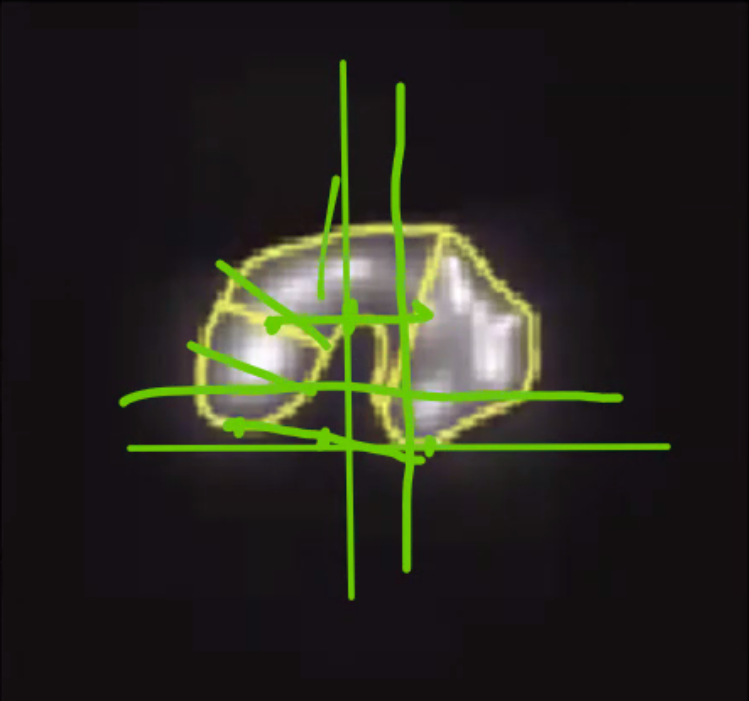

# Juan Boundary Detection Code

In [1]:
import numpy as np
from video_import import *
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.filters.thresholding import threshold_otsu
from skimage.segmentation import mark_boundaries
from skimage.exposure import adjust_log
import cv2 
import pandas as pd

# Video import
data = import_avi("video_1.avi")


# More updated Excel import
# coordinates_file = pd.ExcelFile("xy coordinates for knee imaging 0913.xlsx", engine='openpyxl') # outdated command for my version of xlrd
coordinates_file = pd.read_excel("xy coordinates for knee imaging 0913.xlsx", engine='openpyxl', sheet_name=None)
coordinates_file.keys()
coordinates = coordinates_file['8.29 3rd']

In [ ]:
frames_to_analyze = np.unique(coordinates["Frame Number"])
frames_to_analyze = frames_to_analyze[~np.isnan(frames_to_analyze)]
frames_to_analyze = frames_to_analyze.astype(int)

coordinates["Frame Number"] = np.repeat(frames_to_analyze,4) 

coordinates
frames_to_analyze

Visualization

In [ ]:
frame_preview = 634
frame = data[:,:,:,frame_preview]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8,8))
plt.title(f"Frame {frame_preview}")
plt.imshow(frame)
plt.show()

In [ ]:
points = coordinates[coordinates["Frame Number"] == frame_preview+1][['Points',"X","Y"]]

point1 = (round(points[points["Points"]==1]["X"].iloc[0]), round(points[points["Points"]==1]["Y"].iloc[0]))
point2 = (round(points[points["Points"]==2]["X"].iloc[0]), round(points[points["Points"]==2]["Y"].iloc[0]))
point3 = (round(points[points["Points"]==3]["X"].iloc[0]), round(points[points["Points"]==3]["Y"].iloc[0]))
point4 = (round(points[points["Points"]==4]["X"].iloc[0]), round(points[points["Points"]==4]["Y"].iloc[0]))
line1 = [[point1[0], point2[0]], [point1[1], point2[1]]]
line2 = [[point3[0], point4[0]], [point3[1], point4[1]]]
# mask = np.zeros((binary_image_otsu.shape[0],binary_image_otsu.shape[1]))

print(points)

Alternate points and lines code:

In [ ]:
points = coordinates[coordinates["Frame Number"] == frame_preview + 1][['Points', 'X', 'Y']]

# Create a dictionary to store points
points_dict = {
    f"point{int(row['Points'])}": (round(row["X"]), round(row["Y"]))
    for _, row in points.iterrows()
}

# Access individual points if needed
point1 = points_dict.get("point1")
point2 = points_dict.get("point2")
point3 = points_dict.get("point3")
point4 = points_dict.get("point4")

print(points)


In [ ]:
plt.figure(figsize=(10,10))
# plt.imshow(binary_image_otsu, cmap="gray")
plt.imshow(frame)
plt.scatter(point1[0], point1[1], label="1")
plt.scatter(point2[0], point2[1], label="2")
plt.scatter(point3[0], point3[1], label="3")
plt.scatter(point4[0], point4[1], label="4")
plt.plot(line1[0], line1[1])
plt.plot(line2[0], line2[1])
plt.legend()
plt.show()

# NAIVE THRESHOLDING + EXCEL COORDS

TODO (18 Dec 2024):
- apply translations and cropping to the lines and points 

Notes:
- not sure how effective centering the image using the points will be, since they are very jittery

In [1]:
import cv2
import numpy as np
import pandas as pd
import sys

# Read input file
video = "data\\video_1.avi"
cap = cv2.VideoCapture(video)
if not cap.isOpened():
    print("Error: video could not be opened")
    exit()

# Output file parameters
write_to_file = False
output = None
video_out = "video_1_naive_threshold.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if write_to_file: 
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(video_out, fourcc, 25, (frame_width, frame_height))

# Debug settings
loop = True
if loop: write_to_file = False # To avoid file output corruption

# Import knee section coordinates
coordinates_file = pd.read_excel("data\\xy coordinates for knee-aging three cycles 250303.xlsx", engine='openpyxl', sheet_name=None) # More updated Excel import
print(coordinates_file.keys())
coordinates_sheet = coordinates_file['aging-1']

frames_to_analyze = np.unique(coordinates_sheet["Frame Number"])
frames_to_analyze = frames_to_analyze[~np.isnan(frames_to_analyze)]
frames_to_analyze = frames_to_analyze.astype(int)

coordinates_sheet["Frame Number"] = np.repeat(frames_to_analyze, 4)

# Video processing and output 

start_frame = frames_to_analyze[0] - 1
# start_frame=612
end_frame = frames_to_analyze[-1]
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# print(f'start_frame = {start_frame} \nend_frame = {end_frame}') # --- DEBUG ---

while cap.isOpened():

    # 
    ret, frame = cap.read()
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if not ret or current_frame > end_frame:
        print("End of file or cannot read frame.")
        break
    # print(f"current_frame = {current_frame}") # --- DEBUG ---

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Thresholding requires grayscale image

    # Simple thresholding
    threshold_value = 30 # --- ADJUSTABLE PARAMETER ---
    _, thresholded_frame = cv2.threshold(gray_frame, threshold_value, 255, cv2.THRESH_BINARY) 
    thresholded_frame_colour = cv2.cvtColor(thresholded_frame, cv2.COLOR_GRAY2BGR) 
    # print(f"gray_frame shape (GRAY2BGR) = {cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR).shape}") # --- DEBUG ---
    # print(f"gray_frame shape: {gray_frame.shape}\nframe_out shape: {thresholded_frame_colour.shape}") # --- DEBUG ---

    current_frame_coordinates = coordinates_sheet.loc[coordinates_sheet["Frame Number"] == current_frame, ['Points',"X","Y"]]
    # print(current_frame_coordinates) # --- DEBUG ---

    # Draw points and lines on the frame
    if not current_frame_coordinates.empty:

        points = [(current_frame_coordinates.loc[current_frame_coordinates['Points'] == i, 'X'].values[0],
                   current_frame_coordinates.loc[current_frame_coordinates['Points'] == i, 'Y'].values[0]) for i in range(1, 5)]
        lines = [(points[0], points[1]), (points[2], points[3])]
        # print(points) # --- DEBUG ---
                
        
        # Draw all points
        for point in points:
            cv2.circle(thresholded_frame_colour, point, radius=5, color=(0, 255, 0), thickness=-1)

        # Draw all lines
        for start, end in lines:
            cv2.line(thresholded_frame_colour, start, end, color=(255, 0, 0), thickness=2)

        # Draw all points
        for point in points:
            cv2.circle(frame, point, radius=5, color=(0, 255, 0), thickness=-1)

        # Draw all lines
        for start, end in lines:
            cv2.line(frame, start, end, color=(255, 0, 0), thickness=2)



    # ''' START CENTERING ALGORITHM '''
    # # Center the original frame using the thresholded frame

    # # Find non-zero (white) pixels in the thresholded frame
    # non_zero_coords = cv2.findNonZero(thresholded_frame)

    # # Compute centroid of the white pixels
    # M = cv2.moments(thresholded_frame, binaryImage=True)
    # if M['m00'] != 0:
    #     centroid_x = int(M['m10'] / M['m00'])
    #     centroid_y = int(M['m01'] / M['m00'])
    # else:
    #     centroid_x, centroid_y = frame_width // 2, frame_height // 2  # Default center if no mass

    # # Calculate translation to center the object
    # offset_x = (frame_width // 2) - centroid_x
    # offset_y = (frame_height // 2) - centroid_y

    # # Create translation matrix
    # translation_matrix = np.float32([[1, 0, offset_x], [0, 1, offset_y]])

    # # Apply the translation to the frame from "to_be_corrected_file"
    # corrected_frame = cv2.warpAffine(thresholded_frame_colour, translation_matrix, (frame_width, frame_height))

    # ''' END CENTERING ALGORITHM '''



    # Compare the frames
    frame_out = thresholded_frame_colour
    display_side_by_side(frame, frame_out, "Original (left) vs. Thresholded (right)")

    # File output
    # frame_out = cv2.cvtColor(thresholded_frame, cv2.COLOR_GRAY2BGR)
    if write_to_file: output.write(frame_out)

    # Press 'q' on display window to quit
    if cv2.waitKey(30) & 0xFF == ord('q'): 
        break

    # Loop 
    if loop and current_frame == end_frame:
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # # break # --- DEBUG ---
    # if input("wait...") == 'q': # --- DEBUG --- 
    #     break

cap.release()
if write_to_file: output.release()

# while True: # --- DEBUG ---
#     if cv2.waitKey(10) & 0xFF == ord('q'): 
#         break

cv2.destroyAllWindows()


dict_keys(['aging-1', 'aging-2', 'aging-3'])


ValueError: Length of values (96) does not match length of index (230)

## UTILITY FUNCTIONS ~~(just run it so its loaded in memory)~~ moved to utils.py

In [29]:
import os
from datetime import datetime
import cv2
import numpy as np

def print_last_modified(filepath):
    """
    Prints the last modified date and time of the specified file.

    Parameters:
    - filepath (str): The path to the file.

    Raises:
    - FileNotFoundError: If the specified file does not exist.
    - PermissionError: If the program does not have permission to access the file.
    - Exception: For any other unexpected errors.
    """
    try:
        # Get the last modified timestamp
        date_modified = os.path.getmtime(filepath)
        
        # Convert the timestamp to a human-readable format
        date_modified = datetime.fromtimestamp(date_modified).strftime('%Y-%m-%d %H:%M:%S')
        
        # Print the result
        print(f"file {filepath} last modified {date_modified}")
    
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' does not exist.")
    except PermissionError:
        print(f"Error: Permission denied to access the file '{filepath}'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Function to crop an image with specific margins
def crop_image_with_margins(image, top_margin, left_margin, bottom_margin, right_margin):
    """
    Crop a region from the image by specifying margins.

    Parameters:
    - image: The input image.
    - top_margin: Pixels to remove from the top.
    - left_margin: Pixels to remove from the left.
    - bottom_margin: Pixels to remove from the bottom.
    - right_margin: Pixels to remove from the right.

    Returns:
    - cropped_image: The cropped part of the image.
    """
    # Calculate new coordinates for cropping
    y = top_margin
    x = left_margin
    h = image.shape[0] - top_margin - bottom_margin
    w = image.shape[1] - left_margin - right_margin
    
    # Crop the image
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

def display_side_by_side(frame1:np.ndarray, frame2:np.ndarray, title:str = ""):
    '''
    Displays two frames side-by-side for easy comparison.
    Input: 
    - frame1: First video frame of type DataFrame.
    - frame2: Second video frame of type DataFrame.
    '''

    # Check if the frames have different dimensions
    if frame1.shape[:2] != frame2.shape[:2]:
        # Determine which frame is smaller
        h1, w1 = frame1.shape[:2]
        h2, w2 = frame2.shape[:2]
        
        if h1 < h2 or w1 < w2:
            # Pad the smaller frame to match the dimensions of the larger frame
            top = (h2 - h1) // 2
            bottom = h2 - h1 - top
            left = (w2 - w1) // 2
            right = w2 - w1 - left
            
            frame1 = cv2.copyMakeBorder(frame1, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            top = (h1 - h2) // 2
            bottom = h1 - h2 - top
            left = (w1 - w2) // 2
            right = w1 - w2 - left
            
            frame2 = cv2.copyMakeBorder(frame2, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Combine the frames
    combined_frame = cv2.hconcat([frame1, frame2])

    # If the combined image is too big, resize it.
    if combined_frame.shape[1] > 1920:
        combined_frame = cv2.resize(combined_frame, (int(combined_frame.shape[1] / 2), int(combined_frame.shape[0] / 2)))

    # Display the combined frame
    cv2.imshow(title, combined_frame)

def draw_reference_lines(frame):
    h, w = frame.shape[:2]  
    cv2.line(frame, (w // 2, 0), (w // 2, h), (0, 255, 0), 2)  # Vertical line
    cv2.line(frame, (0, h // 2), (w, h // 2), (0, 255, 0), 2)  # Horizontal line



# CROPPING THE STABILIZED VIDEO

In [ ]:
import cv2
import numpy as np
import sys

# Read file
video = "video_1_corrected_naive_threshold.avi"
cap = cv2.VideoCapture(video)

# Error check 
if not cap.isOpened():
    print("Error: video could not be opened")
    exit()

# Output file 
write_to_file = False
video_out = "video_1_corrected_naive_threshold_cropped.avi"
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(video_out, fourcc, 25, (w, h))

print(f"frame width = {w}\nframe height = {h}")
print_last_modified(video)
print_last_modified(video_out)

while cap.isOpened():

    current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)

    # Read frames 
    ret, frame = cap.read()
    if not ret:
        print("End of file or cannot read frame.")
        break
    
    # Crop the video
    cropped_frame = crop_image_with_margins(frame, 300, 350, 280, 360) 

    # _, cropped_frame = cv2.threshold(cropped_frame, 40, 255, cv2.THRESH_TOZERO) # To remove the background from the grayscale image

    # _, thresholded_frame = cv2.threshold(gray_frame, threshold_value, 255, cv2.THRESH_BINARY)

    # Write frames
    frame_out = cropped_frame
    # display_side_by_side(frame, cropped_frame)
    cv2.imshow("", cropped_frame)
    if write_to_file: output.write(frame_out)

    # Press 'q' to exit
    if cv2.waitKey(30) & 0xFF == ord('q'): 
        break

    loop = True
    if loop and current_frame == end_frame: cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Cleanup 
cap.release()
if write_to_file: output.release()
cv2.destroyAllWindows()


# STABILIZED + CROPPED + OTSU BOUNDARY

Otsu boundary (cv2 version)

In [ ]:
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries

# Read file
video_path = "video_1_corrected_naive_threshold.avi"
cap = cv2.VideoCapture(video_path)

# Error check
if not cap.isOpened():
    print("Error: Video could not be opened")
    exit()

# Output file
write_to_file = False
output_video_path = "video_1_stabilized_cropped_otsuboundaries_cv2.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(output_video_path, fourcc, 25, (frame_width, frame_height))

print(f"Frame width = {frame_width}\nFrame height = {frame_height}")
print_last_modified(video_path)
print_last_modified(output_video_path)

# Custom viewing settings
start_frame = 71 #577
end_frame = 155 #669
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Loop
loop = True
if loop: write_to_file = False # for robustness

while cap.isOpened():

    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Read frame
    ret, frame_bgr = cap.read()
    if not ret or current_frame > end_frame:

        print("End of file or cannot read frame.")
        break

    # Convert to grayscale
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # Crop the video
    frame_cropped = crop_image_with_margins(frame, 300, 350, 280, 360)

    # Apply Gaussian blur
    frame_cropped_blurred = cv2.GaussianBlur(frame_cropped, (11, 11), 0)

    # Apply Otsu threshold
    _, binary_mask_otsu = cv2.threshold(frame_cropped_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Mark boundaries
    frame_with_boundaries = mark_boundaries(frame_cropped, binary_mask_otsu)

    # Convert to OpenCV-compatible format
    boundaries_visualized = (frame_with_boundaries * 255).astype(np.uint8)
    frame_bgr_with_boundaries = cv2.cvtColor(boundaries_visualized, cv2.COLOR_RGB2BGR)


    # Write frames
    if write_to_file:
        output.write(frame_bgr_with_boundaries)


    # Write frame number to image
    # font                   = cv2.FONT_HERSHEY_SIMPLEX
    # bottomLeftCornerOfText = (10,500)
    # fontScale              = 1
    # fontColor              = (255,255,255)
    # thickness              = 1
    # lineType               = 2

    # cv2.putText(frame, current_frame, 
    #     bottomLeftCornerOfText, 
    #     font, 
    #     fontScale,
    #     fontColor,
    #     thickness,
    #     lineType)

    # Display
    cv2.imshow("Otsu Segmentation with Boundaries (cv2 version)", frame_bgr_with_boundaries)
    
    # # Pause
    # if cv2.waitKey() & 0xFF == ord('a'):
    #     pass

    # Press 'q' to exit
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    if loop and current_frame == end_frame: cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)


# Cleanup
cap.release()
if write_to_file:
    output.release()
cv2.destroyAllWindows()


Otsu boundary (skimage version)

In [ ]:
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.filters import threshold_otsu

# Read file
video_path = "video_1_corrected_naive_threshold.avi"
cap = cv2.VideoCapture(video_path)

# Error check
if not cap.isOpened():
    print("Error: Video could not be opened")
    exit()

# Output file
write_to_file = False
output_video_path = "video_1_stabilized_cropped_otsuboundaries_skimage.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(output_video_path, fourcc, 25, (frame_width, frame_height))

print(f"Frame width = {frame_width}\nFrame height = {frame_height}")

while cap.isOpened():

    # Read frame
    ret, frame = cap.read()
    if not ret:
        print("End of file or cannot read frame.")
        break

    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Crop the video
    frame_cropped = crop_image_with_margins(frame, 300, 350, 280, 360)

    # Apply Gaussian blur
    frame_cropped_blurred = cv2.GaussianBlur(frame_cropped, (11, 11), 0)

    # Apply Otsu threshold using skimage
    threshold_otsu_value = threshold_otsu(frame_cropped_blurred)  # Get threshold value
    binary_mask_otsu = frame_cropped_blurred > threshold_otsu_value  # Create binary mask

    # Mark boundaries
    frame_with_boundaries = mark_boundaries(frame_cropped, binary_mask_otsu)

    # Convert to OpenCV-compatible format
    boundaries_visualized = (frame_with_boundaries * 255).astype(np.uint8)
    frame_bgr_with_boundaries = cv2.cvtColor(boundaries_visualized, cv2.COLOR_RGB2BGR)


    # Write frames
    if write_to_file:
        output.write(frame_bgr_with_boundaries)

    # Display the result
    cv2.imshow("Otsu Segmentation with Boundaries (skimage version)", frame_bgr_with_boundaries)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # print()
    # # -- DEBUG ---
    # if input("wait...") == 'q': # --- DEBUG --- 
    #     break

# Cleanup
cap.release()
if write_to_file:
    output.release()
cv2.destroyAllWindows()


Naive threshold boundary

In [ ]:
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries

# Read file
video_path = "video_1_corrected_naive_threshold.avi"
cap = cv2.VideoCapture(video_path)

# Error check
if not cap.isOpened():
    print("Error: Video could not be opened")
    exit()

# Output file
write_to_file = False
output_video_path = "video_1_stabilized_cropped_simpleboundaries_cv2.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if write_to_file:
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter(output_video_path, fourcc, 25, (frame_width, frame_height))

print(f"Frame width = {frame_width}\nFrame height = {frame_height}")
print_last_modified(video_path)
print_last_modified(output_video_path)

# Fixed threshold value
threshold_value = 80  # --- ADJUSTABLE PARAMETER ---

start_frame = 71
end_frame = 155
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

loop = True
if loop: write_to_file = False

while cap.isOpened():

    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Read frame
    ret, frame_bgr = cap.read()
    if not ret or current_frame > end_frame:
        print("End of file or cannot read frame.")
        break

    # current_frame = cv2.CAP_PROP_

    # Convert to grayscale
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # Crop the video
    frame_cropped = crop_image_with_margins(frame, 300, 350, 280, 360)

    # Apply Gaussian blur
    frame_cropped_blurred = cv2.GaussianBlur(frame_cropped, (31, 31), 0)

    # Apply simple threshold
    _, binary_mask_simple = cv2.threshold(frame_cropped_blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Mark boundaries
    frame_with_boundaries = mark_boundaries(frame_cropped, binary_mask_simple.astype(bool))

    # Convert to OpenCV-compatible format
    boundaries_visualized = (frame_with_boundaries * 255).astype(np.uint8)
    frame_bgr_with_boundaries = cv2.cvtColor(boundaries_visualized, cv2.COLOR_RGB2BGR)

    # Write frames
    if write_to_file:
        output.write(frame_bgr_with_boundaries)

    # Display
    cv2.imshow("Simple Thresholding with Boundaries (cv2 version)", frame_bgr_with_boundaries)

    # Press 'q' to exit
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    if loop and current_frame == end_frame: cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)


    # print(current_frame)

# Cleanup
cap.release()
if write_to_file:
    output.release()
cv2.destroyAllWindows()


Idea: 
- ~~partition each frame, find the "lowest point" on the boundary on each side ~~
- ~~draw a line to each "lowest point" and rotate the image so that line is horizontal ~~
- ~~compare Otsu vs simple thresholding for each cycle~~
- ~~ set the vertical centre to be the midpoint of the points ~~

TODO (20 Dec 2024): implement better segmentation for the knee using the logic from desmos 

Future work: 
- we will use better edge detection approaches once the video is more stabilized and centered to a coordinate axis 

# Threshold boundary + morphological operations

In [ ]:
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries
from utils import *

# Read video file
video_path = "video_1_corrected_naive_threshold.avi"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Error: Video could not be opened")

# Output settings
write_to_file = False
output_video_path = "video_1_stabilized_cropped_simpleboundaries_cv2.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if write_to_file:
    output = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 25, (frame_width, frame_height))

# Print video info
print(f"Frame width = {frame_width}\nFrame height = {frame_height}")
print_last_modified(video_path)
if write_to_file:
    print_last_modified(output_video_path)

# Macro Parameters
threshold_value = 80  # Adjustable parameter
loop = True
# start_frame, end_frame = 83, 83 
start_frame, end_frame = 71, 155
if loop:
    write_to_file = False
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Font settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (255, 255, 255)
thickness = 2

# --- MAIN LOOP ---
while cap.isOpened():
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    ret, frame_bgr = cap.read()
    if not ret or current_frame > end_frame:
        print("End of file or cannot read frame.")
        break

    # Preprocessing to improve threshold boundaries
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 
    frame = crop_image_with_margins(frame, 300, 350, 280, 360) # crop irrelevant parts
    frame_blur = cv2.GaussianBlur(frame, (41, 41), 0) # a heavy blur produces a wide boundary, which is good 

    # Thresholding
    # _, binary_mask = cv2.threshold(frame_blur, 100, 255, cv2.THRESH_BINARY) # Simple threshold, second parameter is threshold value
    _, binary_mask = cv2.threshold(frame_blur, 0, 255, cv2.THRESH_OTSU) # Otsu's threshold -- this one is better
    
    # Kernel for morphological operations
    kernel_size = (50, 50)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Mark boundaries
    frame_with_boundaries = mark_boundaries(frame, binary_mask_morph) * 255
    frame_with_boundaries = frame_with_boundaries.astype(np.uint8)
    frame_with_boundaries = cv2.cvtColor(frame_with_boundaries, cv2.COLOR_RGB2BGR)
    frame_out = frame_with_boundaries

    # Split binary mask
    bisection_point = 0.45 # 
    split_idx = round(binary_mask_morph.shape[1] * bisection_point)
    binary_mask_left = binary_mask_morph[:, :split_idx] 
    binary_mask_right = binary_mask_morph[:, split_idx:]

    # Find lowest points
    def find_lowest_point(mask: np.ndarray, offset: int = 0):
        y, x = np.nonzero(mask)
        if y.size == 0:
            return None
        idx = np.argmax(y)
        return x[idx] + offset, y[idx]

    left_lowest_point = find_lowest_point(binary_mask_left)
    right_lowest_point = find_lowest_point(binary_mask_right, offset=split_idx)

    # Draw points and line
    if left_lowest_point:
        cv2.circle(frame_out, left_lowest_point, 3, (0, 0, 255), -1)
    if right_lowest_point:
        cv2.circle(frame_out, right_lowest_point, 3, (0, 0, 255), -1)
    if left_lowest_point and right_lowest_point:
        cv2.line(frame_out, left_lowest_point, right_lowest_point, (0, 0, 255), 1)

    # Get the angle drawn between the line and the horizontal axis 
    delta = [ 
        right_lowest_point[0] - left_lowest_point[0], # (delta_x, delta_y)
        right_lowest_point[1] - left_lowest_point[1]
        ] 
    angle = np.arctan2(delta[1], delta[0])
    angle_deg = np.degrees(angle)
    
    # Rotate the frame by the angle
    (h, w) = frame_out.shape[:2]
    frame_center = (round(w / 2), round(h / 2))
    rotation_matrix = cv2.getRotationMatrix2D(frame_center, angle_deg, 1.0)
    # frame_out = cv2.warpAffine(frame_out, rotation_matrix, (w,h)) # Rotate the frame based on the angle

    # Pre-rotation: Calculate the midpoint of the left and right lowest points
    left_point = np.array(left_lowest_point, dtype=float)
    right_point = np.array(right_lowest_point, dtype=float)
    midpoint_pre_rotation = (round((left_point[0] + right_point[0]) / 2), round((left_point[1] + right_point[1]) / 2)) # Get the midpoint between the two points

    # Apply the rotation matrix to the midpoint using matrix multiplication
    rotated_midpoint = np.dot(rotation_matrix[:, :2], midpoint_pre_rotation) + rotation_matrix[:, 2]

    # Draw the rotated midpoint on the frame
    # cv2.circle(frame_out, (int(rotated_midpoint[0]), int(rotated_midpoint[1])), 3, (0, 0, 255), -1)

    # Calculate the translation needed to move the midpoint to the center of the frame
    desired_center = (w / 2, 3*h / 4)
    translation_vector = np.array([desired_center[0] - rotated_midpoint[0], desired_center[1] - rotated_midpoint[1]])

    # Create the translation matrix
    translation_matrix = np.array([[1, 0, translation_vector[0]], [0, 1, translation_vector[1]]])

    # Apply the translation to the entire frame
    # frame_out = cv2.warpAffine(frame_out, translation_matrix, (w, h))


    # Draw reference lines
    # draw_reference_lines(frame_out)

    # Print current frame number on the bottom-left corner
    position = (10,h - 10)
    cv2.putText(frame_out, str(current_frame), position, font, font_scale, color, thickness, lineType=cv2.LINE_AA)

    # Display frames
    cv2.imshow("Binary Mask Left", binary_mask_left)
    cv2.imshow("Binary Mask Right", binary_mask_right)
    cv2.imshow(f"Frames {start_frame} to {end_frame}", frame_out)

    # Write to output file
    if write_to_file:
        output.write(frame_out)

    # Exit on 'q'
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    # Loop video
    if loop and current_frame == end_frame:
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

cap.release()
if write_to_file:
    output.release()
cv2.destroyAllWindows()


Update for 20 Jan 2025:
- refactored the code for simplicity
- got the lowest points on the left and right sides 
- drew the line between the points 
- got the angle between the points 
- rotated the image by the angle 

Update for 13 Jan 2025:
- added morphological operations to refine the boundary for frames 71-155 
- applied an elliptic kernel to refine the boundary for frames 71-155, in preparation for future processing

TODO:
- (low priority) investigate possible sources of rounding error and try to minimize it?
- (low priority) cut the image into 10 radial segments
- (low priority) look at the injection data that Juan sent so we can discuss it with Dr. Chen's students. want to see if we can reduce the noise so we can process it more effectively 
- (low-medium priority) read about diffusion models for de-noising (Dr. Liang will send blogs and organize reading sessions)
- (medium priority) organize the code into separate programs to increase modularity 

TODO: (2 tasks)
- (1)
- look at the new video, see if they're comparable
- try to apply the scale length so we can rescale it 
- see how the existing techniques work on the new video 
- (2)
- increase the contrast 
- try to get the black boundary
- get the yellow points
- fit the blue line using a least-squares approach

FUTURE: 
- see if we can use the angle that Huizhu sent to straighten the frame 
- verify which side of the frame is the upper leg bone

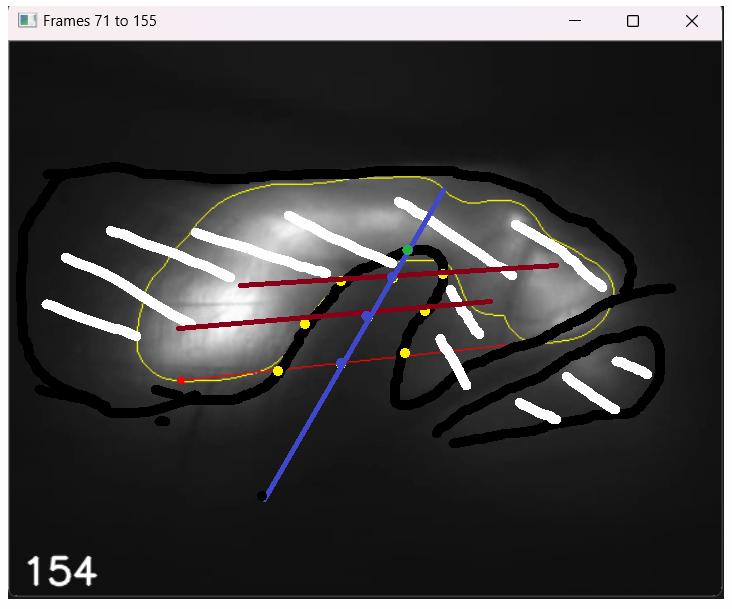



# Attempted transforms to get the black boundary

In [ ]:
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries
from utils import *

# Read video file
video_path = "data\\video_1.avi"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Error: Video could not be opened")

# Output settings
output_video_path = "video_1_stabilized_cropped_simpleboundaries_cv2.avi"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 25, (frame_width, frame_height))

# Print video info
# print(f"Frame width = {frame_width}\nFrame height = {frame_height}")
# print_last_modified(video_path)
# print_last_modified(output_video_path)

# Set start and end frames
start_frame, end_frame = 71, 155
total_frames = end_frame - start_frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Print time info
frames_per_second = 25
print(f"first frame = {start_frame}, last frame = {end_frame}")
print(f"total_frames = {total_frames}")
print(f"frames_per_second = {frames_per_second}")
print(f"seconds/cycle = {total_frames/frames_per_second}")

# Font settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (255, 255, 255)
thickness = 2

# Gamma correction function
def gamma_correction(img, gamma=1.2):
    img_gamma = np.power(img / 255.0, gamma) * 255
    return np.uint8(img_gamma)

# Log transform function
def log_transform(img):
    c = 255 / np.log(1 + np.max(img))
    log_img = c * np.log(1 + img.astype(np.float32))
    return np.uint8(cv2.normalize(log_img, None, 0, 255, cv2.NORM_MINMAX))

# Exponential transform function
def exponential_transform(img, factor=1.5):
    # Apply exponential transformation to brighten the image
    exp_img = np.power(img / 255.0, factor) * 255
    return np.uint8(np.clip(exp_img, 0, 255))  # Clip values to the valid range [0, 255]

# Sigmoid transform function
def sigmoid_transform(image, k=10, I0=128): # k is strength, I0 is center of contrast enhancement
    image = image.astype(np.float32)  # Convert to float for precision
    transformed = 255 / (1 + np.exp(-k * (image - I0) / 255))
    return np.uint8(transformed)  # Convert back to uint8

# Iterate over all frames
while cap.isOpened():

    # Get current frame number
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Catch ReadErrors 
    ret, frame_bgr = cap.read()
    if not ret:
        print("End of file or cannot read frame.")
        break
    
    # Preprocessing 
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    frame = np.rot90(frame, k = -1)
    # frame = crop_image_with_margins(frame, 300, 370, 280, 360)  # Crop irrelevant parts
    # frame = cv2.GaussianBlur(frame, (31, 31), 0)  # A heavy blur produces a wide boundary
    
    


    # Center and crop the frame
    frame = centroid_stabilization(frame, blur_strength=81)
    # frame = crop_image_with_margins(frame, 200,300,200,300)

    # Scale down the brightness
    # min_brightness = np.min(frame[frame > 0]) # Minimum non-zero brightness
    # frame_adjusted = frame - min_brightness
    # frame_adjusted = np.maximum(frame_adjusted, 0) # Set negative values to 0

    # Commit the brightness adjustment
    # frame = frame_adjusted

    # Apply various transforms
    # frame_gamma = gamma_correction(frame, 2.2)
    # frame_log = log_transform(frame)
    # frame_exp = exponential_transform(frame, 0.3)
    # frame_exp = gamma_correction(frame_exp, 0.5)

    # TODO: Adjust parameters for better sigmoid transformation
    # frame_sigmoid = sigmoid_transform(frame, k = 8, I0 = 40) # Best so far: k = 8, I0 = 40
    # frame_sigmoid1 = sigmoid_transform(frame, k = 10, I0 = 90)

    # Thresholding using Otsu's method
    # _, gray_mask = cv2.threshold(frame, 0, 255, cv2.THRESH_OTSU)
    # _, gamma_mask = cv2.threshold(frame_gamma, 0, 255, cv2.THRESH_OTSU)
    # _, log_mask = cv2.threshold(frame_log, 0, 255, cv2.THRESH_OTSU)
    # _, exp_mask = cv2.threshold(frame_exp, 0, 255, cv2.THRESH_OTSU)
    # _, exp_mask = cv2.threshold(frame_exp, 40, 255, cv2.THRESH_BINARY)
    # _, sigmoid_mask = cv2.threshold(frame_sigmoid, 0, 255, cv2.THRESH_OTSU) # Weak sigmoid + Otsu thresholding -- maybe this one is pretty good
    # _, sigmoid_mask = cv2.threshold(frame_sigmoid, 150, 255, cv2.THRESH_BINARY) # Simple thresholding
    # _, sigmoid1_mask = cv2.threshold(frame_sigmoid1, 120, 255, cv2.THRESH_OTSU) 
    # _, sigmoid1_mask = cv2.threshold(frame_sigmoid1, 100, 255, cv2.THRESH_BINARY) 


    # Overlay masks
    # frame = np.maximum(frame, gray_mask)
    # frame_gamma = np.maximum(frame_gamma, gamma_mask)
    # frame_log = np.maximum(frame_log, log_mask)
    # frame_exp = np.maximum(frame_exp, exp_mask)
    # frame_sigmoid = np.maximum(frame_sigmoid, sigmoid_mask)
    # frame_sigmoid1 = np.maximum(frame_sigmoid1, sigmoid1_mask)

    # Test point
    # cv2.circle(frame, (270,220), 3, (255,255,255), -1) 
    # print(frame[270,220])

    # Stack images for comparison
    # frame = np.hstack((frame, frame_sigmoid))
    # frame_ = np.hstack((frame_sigmoid, frame_sigmoid1))
    # frame = np.vstack((frame, frame_out_))
    frame = frame

    # Rescale frame
    pixel_scale = 23.9416 # pixels / mm
    frame, rescale_factor = rescale_frame(frame, pixel_scale, scale_factor=1.4)

    # Draw 1 cm scale along the bottom of the frame
    draw_scale_bar(frame, pixel_scale*rescale_factor) # Rescale the drawn bar 

    # Print current frame number on the bottom-left corner
    h,w = frame.shape
    position = (10, h - 10)
    cv2.putText(frame, str(current_frame), position, 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, 
                color = (255, 255, 255), thickness = 2, lineType=cv2.LINE_AA)
    
    # Write scale length on frame
    cv2.putText(frame, f"({pixel_scale*10} px = 1 cm)", (11*w//16, h-15), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.4, 
                color=(195,195,195), thickness=1, lineType=cv2.LINE_AA)

    # Draw centre lines
    # draw_reference_lines(frame)

    # Display frames
    cv2.imshow(f"Normal knee: Frames {start_frame} to {end_frame}", frame)

    # Write to output file
    write_to_file = False
    if write_to_file:
        output.write(frame)

    # Exit on 'q'
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

    # Loop video
    loop = True
    if loop and current_frame >= end_frame:
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

cap.release()
output.release()    
cv2.destroyAllWindows()


# Update for 10 Feb 2025:
- currently testing some non-linear brightness transformations to get the contour of the bone (dark region) more clearly
- sigmoid transformation is the most promising so far (draw picture to give an idea) 

# Update for 24 Feb 2025 
- implemented scale length 

# TODO:
- try to get the line representing the bone manually, for the frames that we can't do automatically 
- maybe original frame + otsu thresholding is good enough for most of the frames
- try adding some of the strong sigmoid-transformed frames to strengthen the boundary for the original frame 

Future:
- plot the intensity from the knee 3 parts (like Juan) to compare the normal vs old knee data 

Spatial scale: 23.9416 pixels/mm
Time scale: 25 fps